# Introducing RNNs and LSTMs

In [1]:
import sys
import autograd
import autograd.misc.optimizers as optim
import autograd.numpy as np
from autograd import grad

import matplotlib.pyplot as plt
%matplotlib inline

## Resources

You may find the following resources helpful for understanding how RNNs and LSTMs work:

* [The Unreasonable Effectiveness of RNNs (Andrej Karpathy)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Recurrent Neural Networks Tutorial (Wild ML)](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/)
* [Understanding LSTM Networks (Chris Olah)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Character-Level Language Model

In [2]:
# Load the Shakespeare text
import urllib.request
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
filename = 'shakespeare_data.txt'
urllib.request.urlretrieve(url, filename)


data_file = open(filename, 'r')
text = data_file.read()
data_file.close()

print("------------------------------")
# Print a sample of the text
print(text[:100])
data_length = len(text)
vocab = list(set(text))
vocab_size = len(vocab)   # + 1      # The extra + 1 is for the end-of-string token

char_to_index = { char:index for (index,char) in enumerate(vocab) }
index_to_char = { index:char for (index,char) in enumerate(vocab) }

print("The vocabulary contains {}".format(vocab))
print("------------------------------")
print("TOTAL NUM CHARACTERS = {}".format(data_length))
print("NUM UNIQUE CHARACTERS = {}".format(vocab_size))
print('char_to_index {}'.format(char_to_index))

------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
The vocabulary contains ['&', 'a', 'J', 'q', 'i', 'G', 'N', 'C', 'Q', 'd', 't', 'l', 'I', 'B', 'y', 'm', '?', '-', 'P', 'R', 'K', 'V', 'r', 'Z', 'E', '$', 's', 'f', 'O', '.', 'X', 'c', 'h', 'W', ' ', 'L', 'H', '3', 'u', 'x', 'Y', 'S', 'v', ',', 'M', 'j', '\n', 'g', '!', 'T', 'z', 'w', 'b', 'n', "'", 'p', 'U', 'e', 'o', 'k', ':', 'D', ';', 'A', 'F']
------------------------------
TOTAL NUM CHARACTERS = 1115394
NUM UNIQUE CHARACTERS = 65
char_to_index {'&': 0, 'a': 1, 'J': 2, 'q': 3, 'i': 4, 'G': 5, 'N': 6, 'C': 7, 'Q': 8, 'd': 9, 't': 10, 'l': 11, 'I': 12, 'B': 13, 'y': 14, 'm': 15, '?': 16, '-': 17, 'P': 18, 'R': 19, 'K': 20, 'V': 21, 'r': 22, 'Z': 23, 'E': 24, '$': 25, 's': 26, 'f': 27, 'O': 28, '.': 29, 'X': 30, 'c': 31, 'h': 32, 'W': 33, ' ': 34, 'L': 35, 'H': 36, '3': 37, 'u': 38, 'x': 39, 'Y': 40, 'S': 41, 'v': 42, ',': 43, 'M': 44, 'j': 45, '\n': 46,

## RNN

Recurrent Neural Network Diagram

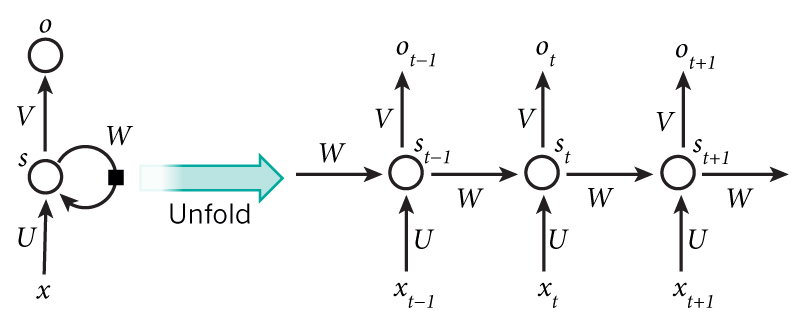

(Image from the [Wild ML RNN Tutorial](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/))



The update of an RNN is expressed by the following formulas:

$$
h_t = \tanh(U x_t + W h_{t-1} + b_h)
$$

$$
y_t = \text{softmax}(V h_t + b_y)
$$

Here, each $x_t$ is a _character_---in this example, there are 65 unique characters. Since in each step the model takes as input a character and outputs a prediction for the next character in the sequence, both $x_t$ and $o_t$ are 65-dimensional vectors, i.e., $x_t, o_t \in \mathbb{R}^{65}$. We can choose any dimension for the hidden state $h_t$; in this case, we will use $h_t \in \mathbb{R}^{100}$. With this setup, the dimensions of $U$, $W$, and $V$ are $100 \times 65$, $100 \times 100$, and $65 \times 100$, respectively.

For a vector $\mathbf{x}$, we have:

$$
\text{softmax}(\mathbf{x})_i = \frac{e^{\mathbf{x}_i}}{\sum_j e^{\mathbf{x}_j}}
$$

Another way of visualizing RNNs is:                             

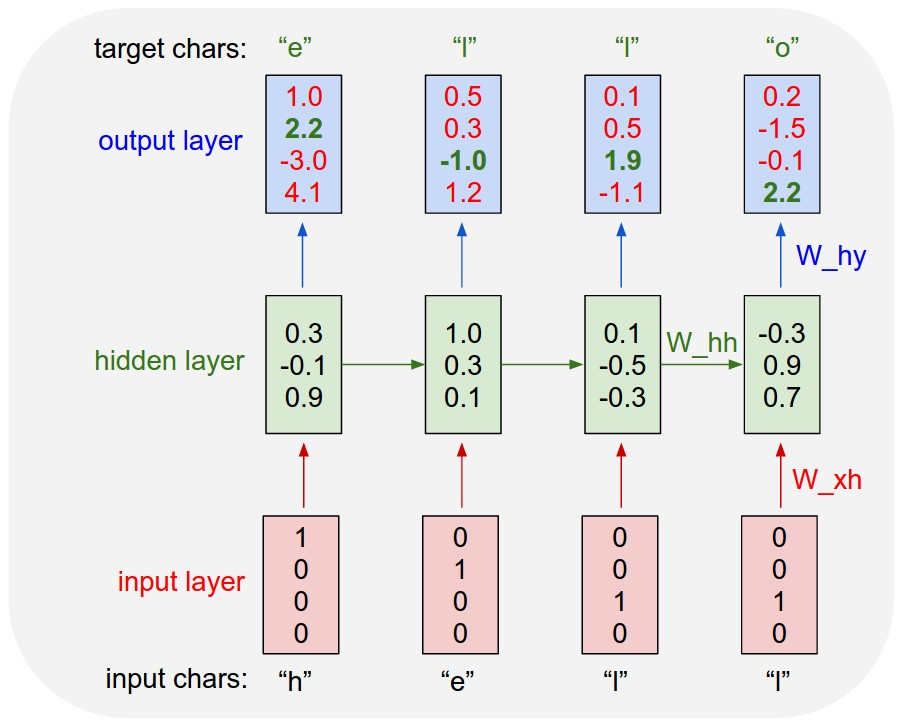

In [ ]:
# Warning: not numerically stable
def softmax_unstable(x):
    return np.exp(x) / np.sum(np.exp(x))

In [ ]:
softmax_unstable([1, 2, 1000])

/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 0.,  0., nan])

In [ ]:
# Numerically stable version
def softmax(x):
    exponential = np.exp(x - np.max(x))
    return exponential / np.sum(exponential)

In [ ]:
softmax([1,2,1000])

array([0., 0., 1.])

In [ ]:
def log_softmax(x):
    return np.log(softmax(x) + 1e-6)

In [ ]:
log_softmax([1,2,1000])

array([-1.38155106e+01, -1.38155106e+01,  9.99999500e-07])

In [ ]:
def initialize_params(input_size, hidden_size, output_size):
    params = {
        'U': np.random.randn(hidden_size, input_size) * 0.01,
        'W': np.random.randn(hidden_size, hidden_size) * 0.01,
        'V': np.random.randn(output_size, hidden_size) * 0.01,
        'b_h': np.zeros(hidden_size),
        'b_o': np.zeros(output_size)
    }
    return params

In [ ]:
def initialize_hidden(hidden_size):
    return np.zeros(hidden_size)

In [ ]:
def model(params, x, h_prev):
    h = np.tanh(np.dot(params['U'], x) + np.dot(params['W'], h_prev) + params['b_h'])
    y = softmax(np.dot(params['V'], h) + params['b_o'])
    return y, h

In [ ]:
def criterion(output, target):
    """Negative log-likelihood loss. Useful for training a classification problem with n classes.
    """
    output = np.log(output)
    return -output[target]

In [ ]:
def loss(params, input_seq, target_seq, opts):
    """
    Compute the loss of RNN based on data.
    
    :param params: dict of str: tensor, including keys U, W, v, b_h, b_o.
    :param input_seq: list of str. Input string.
    :param target_seq: list of str. Target string.
    :param opts: dict of str: int. Including keys input_size, hidden_size, output_size.
    
    :return final_string: str. 
    """
    hidden = initialize_hidden(opts['hidden_size'])
    loss = 0
    
    for i in range(len(input_seq)):
        # output, hidden = model(params, input_seq[i], hidden)
        # loss += criterion(output, target_seq[i])
        
        x = input_seq[i]
        
        hidden = np.tanh(np.dot(params['U'], x) + np.dot(params['W'], hidden) + params['b_h'])
        output = softmax(np.dot(params['V'], hidden) + params['b_o'])
        
        loss += criterion(output, target_seq[i])
    
    return loss

In [ ]:
loss_grad = grad(loss)

```
def sgd(grad, init_params, callback=None, num_iters=200, step_size=0.1, mass=0.9):
    """Stochastic gradient descent with momentum.
    grad() must have signature grad(x, i), where i is the iteration number."""
```

In [ ]:
def create_one_hot(j, length):
    vec = np.zeros(length)
    vec[j] = 1
    return vec

In [ ]:
def sample(params, initial, length, opts):
    """
    Sampling a string with a Recurrent neural network.
    
    :param params: dict of str: tensor, including keys U, W, v, b_h, b_o
    :param initial: str. Beginning character.
    :param length: length of the generated string.
    :param opts: dict of str: int. Including keys input_size, hidden_size, output_size.
    
    :return final_string: str. 
    """
    hidden = initialize_hidden(opts['hidden_size'])
    current_char = initial
    final_string = initial
    
    for i in range(length):
        x = create_one_hot(char_to_index[current_char], opts['input_size'])
        output, hidden = model(params, x, hidden)
        
        p = output
        current_index = np.random.choice(range(vocab_size), p=p.ravel())
        current_char = index_to_char[current_index]
        final_string += current_char
    
    return final_string

In [ ]:
def main():
    # Use non-overlapping 25-character chunks for training
    sequence_length = 50
    num_epochs = 1
    print_every = 100
    evaluate_every = 100
    lr = 1e-2

    opts = {
        'input_size': vocab_size,
        'hidden_size': 100,
        'output_size': vocab_size,
    }

    params = initialize_params(opts['input_size'], opts['hidden_size'], opts['output_size'])

    for ep in range(num_epochs):
        # i = 0
        # while i * sequence_length + 1 < 10000:
        for i in range(data_length // sequence_length):
            start = i * sequence_length
            end = start + sequence_length + 1
            chunk = text[start:end]

            input_chars = chunk[:-1]
            target_chars = chunk[1:]

            input_seq = [char_to_index[c] for c in input_chars]
            target_seq = [char_to_index[c] for c in target_chars]

            input_seq_one_hot = [create_one_hot(j, vocab_size) for j in input_seq]

            example_loss = loss(params, input_seq_one_hot, target_seq, opts)

            grad_params = loss_grad(params, input_seq_one_hot, target_seq, opts)
            for param in params:
                gradient = np.clip(grad_params[param], -5, 5)
                params[param] -= lr * gradient

            if i % print_every == 0:
                print("LOSS = {}".format(example_loss))
                # print(grad_params)

            if i % evaluate_every == 0:
                sampled_string = sample(params, initial='a', length=100, opts=opts)
                print(sampled_string)

            # i += 1

In [ ]:
main()

LOSS = 224.98193805426888
a##H0p:NFuw2612P;&?"wmx3L&3]k:(JirhfK}4'e>IOR}(N&[w/,-Gvu$k;Ac!WhC,-9R;lK%a_<6?m-b0!O`>8EVGf:*rs91k*6
LOSS = 148.9877863644219
ac  ta see ts a ihluh l   ceen c  ll T yogsls es,hesoln victWl 
hh
l
rue fetobm]edt sO  ee
 toh ,r e 
LOSS = 147.90974929746028
aS y uklte motula'
  a  t Naat nheotp
  htrisgsa  t wf ledalS w `hd  ay  <hhr aneth 6e  h  evthmtag d
LOSS = 145.2010039488159
a
,d  Mh sl
  oa
ne  eh
ara,tetwr oan r theg tk mt
su,un fice thmnsngsaastheimen
rat shoosdtertftnelh
LOSS = 135.47662018849095
alhogsec fae ponkRneag  han lr  4 thisU dhi:e T.s Iek
  WonoLn  fecomae gacp ghenpla bye sathan tW hi
LOSS = 139.07132240088413
avur suln,mon,
 lwy  Bo
tyaet  wofheesoli tharee
 IDose,rsa
  .ysileelencsnsteTr theuc thuleney worae
LOSS = 139.64135487756587
ahes tyougrer En
  Tobmrtemdg,tentisunwotf teit  Aft,  Tekelad,anke lfan$rsessi}?ealthial w[e  Ils 
 
LOSS = 117.61177218339637
a  un to        a pivy caleimony in wAare on  lowospin hoce lime oo Csofe torede

KeyboardInterrupt: ignored

## Long Short-Term Memory Networks (LSTMs)

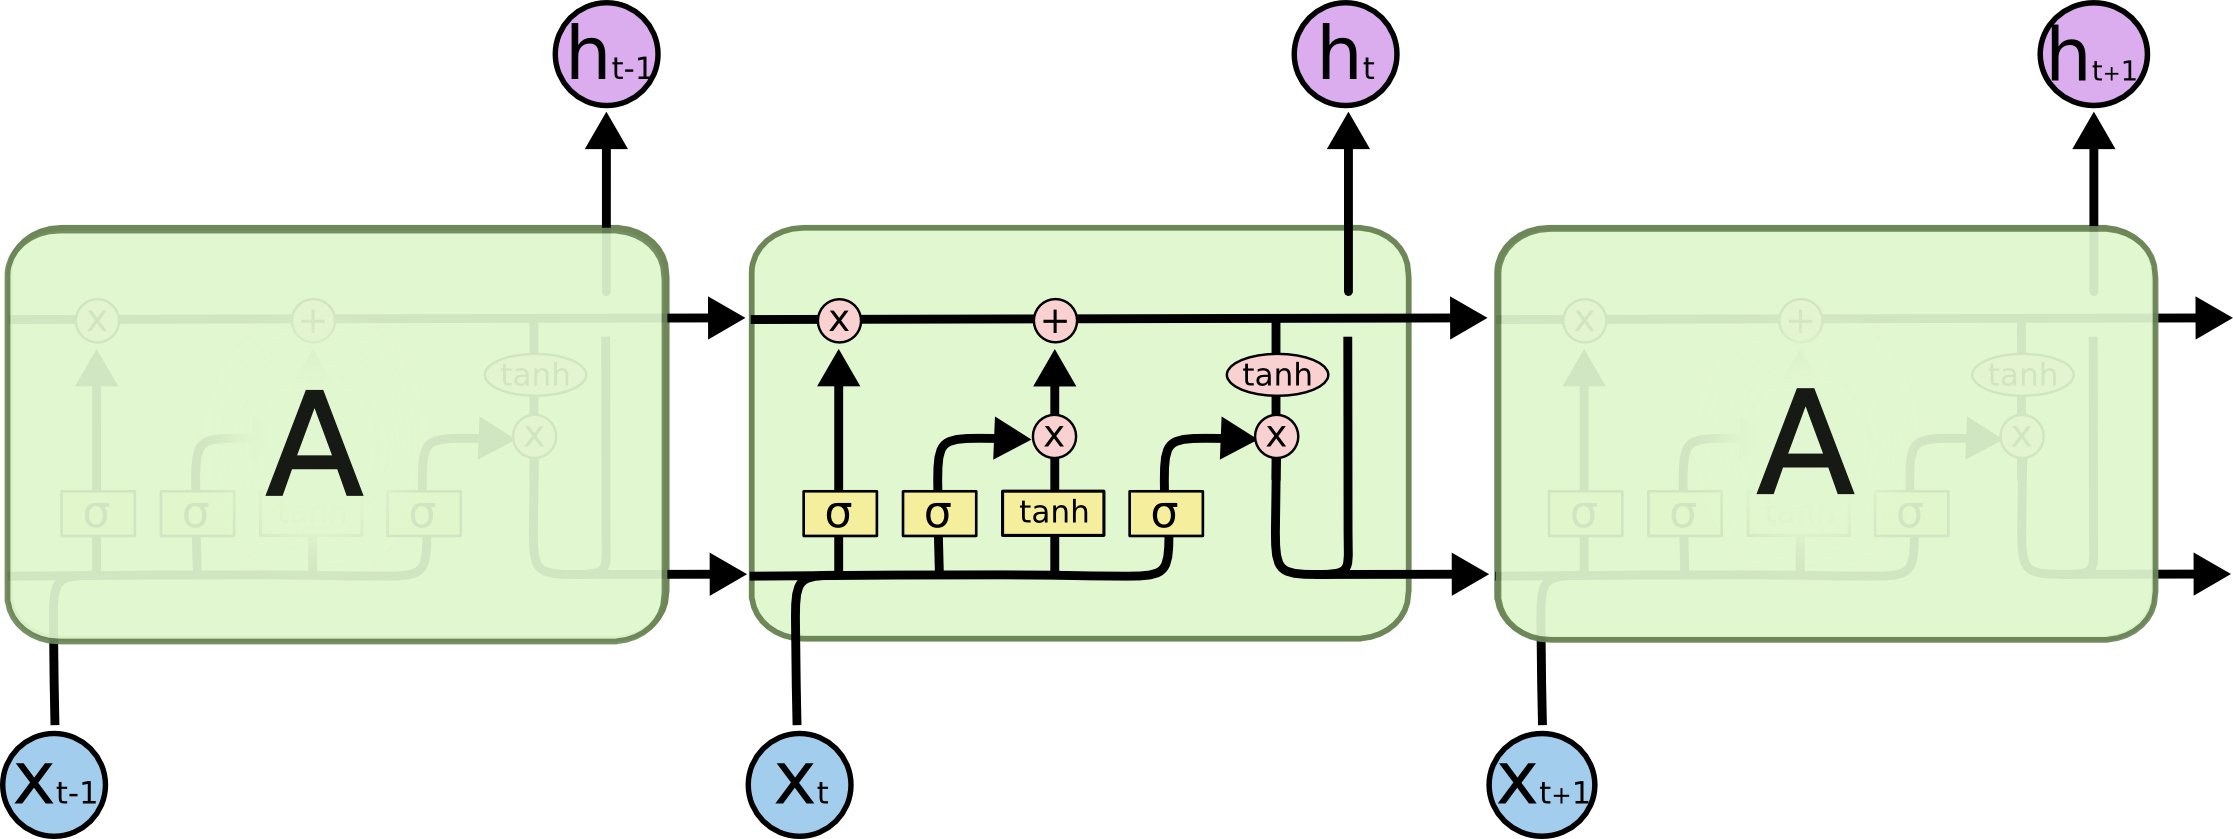


The update of an LSTM is given by the following equations:

$$
i_t = \sigma(U_i x_t + W_i h_{t-1} + b_i)
$$

$$
f_t = \sigma(U_f x_t + W_f h_{t-1} + b_f)
$$

$$
o_t = \sigma(U_o x_t + W_o h_{t-1} + b_o)
$$

$$
\tilde{C}_t = \tanh(U_C x_t + W_C h_{t-1} + b_C)
$$

$$
C_t = i_t * \tilde{C}_t + f_t * C_{t-1}
$$

$$
h_t = o_t * \tanh(C_t)
$$


In [ ]:
def initialize_params(input_size, hidden_size, output_size):
    params = {
        'U_i': np.random.randn(hidden_size, input_size) * 0.01,
        'W_i': np.random.randn(hidden_size, hidden_size) * 0.01,
        'b_i': np.zeros(hidden_size),
        
        'U_f': np.random.randn(hidden_size, input_size) * 0.01,
        'W_f': np.random.randn(hidden_size, hidden_size) * 0.01,
        'b_f': np.zeros(hidden_size),
        
        'U_o': np.random.randn(hidden_size, input_size) * 0.01,
        'W_o': np.random.randn(hidden_size, hidden_size) * 0.01,
        'b_o': np.zeros(hidden_size),
        
        'U_c': np.random.randn(hidden_size, input_size) * 0.01,
        'W_c': np.random.randn(hidden_size, hidden_size) * 0.01,
        'b_c': np.zeros(hidden_size),
        
        'V': np.random.randn(output_size, hidden_size) * 0.01,
        'b': np.zeros(output_size)
    }
    return params

In [ ]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))
def model(params, x, h_prev, C_prev):
    i_t = sigmoid(np.dot(params['U_i'], x) + np.dot(params['W_i'], h_prev) + params['b_i'])
    f_t = sigmoid(np.dot(params['U_f'], x) + np.dot(params['W_f'], h_prev) + params['b_f'])
    o_t = sigmoid(np.dot(params['U_o'], x) + np.dot(params['W_o'], h_prev) + params['b_o'])
    
    C_t_tilde = np.tanh(np.dot(params['U_c'], x) + np.dot(params['W_c'], h_prev) + params['b_c'])
    C_t = i_t * C_t_tilde + f_t * C_prev
    h_t = o_t * np.tanh(C_t)
    
    y = softmax(np.dot(params['V'], h_t) + params['b'])
    return y, h_t, C_t

In [ ]:
def initialize_hidden(hidden_size):
    return np.zeros(hidden_size), np.zeros(hidden_size)

In [ ]:
def loss(params, input_seq, target_seq, opts):
    """
    Compute the loss of RNN based on data.
    
    :param params: dict of str: tensor, including keys U, W, v, b_h, b_o.
    :param input_seq: list of str. Input string.
    :param target_seq: list of str. Target string.
    :param opts: dict of str: int. Including keys input_size, hidden_size, output_size.
    
    :return final_string: str. 
    """
    hidden, cell = initialize_hidden(opts['hidden_size'])
    loss = 0
    
    for i in range(len(input_seq)):
        x = input_seq[i]
        
        i_t = sigmoid(np.dot(params['U_i'], x) + np.dot(params['W_i'], hidden) + params['b_i'])
        f_t = sigmoid(np.dot(params['U_f'], x) + np.dot(params['W_f'], hidden) + params['b_f'])
        o_t = sigmoid(np.dot(params['U_o'], x) + np.dot(params['W_o'], hidden) + params['b_o'])

        C_t_tilde = np.tanh(np.dot(params['U_c'], x) + np.dot(params['W_c'], hidden) + params['b_c'])
        cell = i_t * C_t_tilde + f_t * cell
        hidden = o_t * np.tanh(cell)

        output = softmax(np.dot(params['V'], hidden) + params['b'])
        
        loss += criterion(output, target_seq[i])
    return loss

loss_grad = grad(loss)

In [ ]:
def sample(params, initial, length, opts):
    """
    Sampling a string with a Recurrent neural network.
    
    :param params: dict of str: tensor, including keys U, W, v, b_h, b_o
    :param initial: str. Beginning character.
    :param length: length of the generated string.
    :param opts: dict of str: int. Including keys input_size, hidden_size, output_size.
    
    :return final_string: str. 
    """
    hidden, cell = initialize_hidden(opts['hidden_size'])
    current_char = initial
    final_string = initial
    
    for i in range(length):
        x = create_one_hot(char_to_index[current_char], opts['input_size'])
        output, hidden, cell = model(params, x, hidden, cell)
        
        p = output
        current_index = np.random.choice(range(vocab_size), p=p.ravel())
        current_char = index_to_char[current_index]
        final_string += current_char
    
    return final_string

In [ ]:
main()

LOSS = 224.99461616647585
aVL;RAw *%)IRh.WAp0;.,&9i5CjcU g$wNZbG|7VxxY|'s986 P)*:MMJGiDafY>.6/7#
C9%1n5H10SuBu|Q o e>%$ui7Stmq3
LOSS = 155.57015537773387
alnedJ8-hs)ooelat Wws d nha @ef  r$,uaam .eeo h[
isun et [ rtg
nfatPeeret-hefesi >wt:d& edteugh tr   
LOSS = 150.35404560782607
a  St'dWd et lysdue
th 
a otc
nle sasowcl doenaa ii tc re iiTba b(arii .ddsap  cgeii. hrebehn ncahnh 
LOSS = 153.155353950695
aA  e'is blesr les  Miteihalnyd 
p6lmAn st mrfe  enp hlmos
 
Br1'hes*o n
hae,riyr  ot f  rtvei f o rh
LOSS = 153.31899768684886
anlsg(n
tce
gs >a aie<n snoc hnn a aki,e  d   s eelrrnoe ;oscii@iekeldlep g 
ael  wydeo omn,s rclfnd 
LOSS = 156.79972068145648
avpndmwf oc
ly ana ehas de iae  ,
t si h4esytttdnen 
It  tbetr tal heh i#steeeawncs tese
omgo ttf lro
LOSS = 158.54915740184993
aokrb deen wowcs,heiTlnas fetrs tueAedsbnledt ern
ee ,eeihInrogIiowuhensf:.oa6aeeiterv d
dtlntn}tda s
LOSS = 145.25074918237888
aABld  sinoa e  re   anutrfnIgeiO ,oo aewm oaeb
issT sa
 o zros nsw e  h    aur 

KeyboardInterrupt: ignored